# Network Traffic Anomaly Detection
# Data Preprocessing, Visualization, and Model Training

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
import joblib
import warnings
warnings.filterwarnings('ignore')

## 1. Data Loading and Initial Exploration

In [3]:
print("Loading dataset...")

df = pd.read_csv("Dataset/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv")

Loading dataset...


In [4]:
print(f"Dataset loaded. Shape: {df.shape}")

Dataset loaded. Shape: (288602, 79)


In [5]:
# Display sample data
print("\nSample data:")
df.head()


Sample data:


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,22,166,1,1,0,0,0,0,0.0,0.0,...,32,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
1,60148,83,1,2,0,0,0,0,0.0,0.0,...,32,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
2,123,99947,1,1,48,48,48,48,48.0,0.0,...,40,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
3,123,37017,1,1,48,48,48,48,48.0,0.0,...,32,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
4,0,111161336,147,0,0,0,0,0,0.0,0.0,...,0,1753752.625,2123197.578,4822992,95,9463032.7,2657727.996,13600000,5700287,BENIGN


In [6]:
# Check data types and missing values
print("\nData types:")
print(df.dtypes)


Data types:
 Destination Port                int64
 Flow Duration                   int64
 Total Fwd Packets               int64
 Total Backward Packets          int64
Total Length of Fwd Packets      int64
                                ...   
Idle Mean                      float64
 Idle Std                      float64
 Idle Max                        int64
 Idle Min                        int64
 Label                          object
Length: 79, dtype: object


In [7]:
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
 Destination Port              0
 Flow Duration                 0
 Total Fwd Packets             0
 Total Backward Packets        0
Total Length of Fwd Packets    0
                              ..
Idle Mean                      0
 Idle Std                      0
 Idle Max                      0
 Idle Min                      0
 Label                         0
Length: 79, dtype: int64


# 2. Data Preprocessing

In [8]:
# Handle missing values
print("Handling missing values...")
# Replace missing values in numeric columns with mean
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

Handling missing values...


In [9]:
# Remove rows with any remaining missing values
df = df.dropna()
print(f"Shape after handling missing values: {df.shape}")

Shape after handling missing values: (288602, 79)


In [10]:
# Convert non-numeric columns if any
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
if 'Label' in categorical_cols:
    categorical_cols.remove('Label')  # Keep Label as is

print(f"Converting {len(categorical_cols)} categorical columns...")
for col in categorical_cols:
    df[col] = pd.factorize(df[col])[0]

Converting 1 categorical columns...


In [11]:
# Check for infinite values and replace with column max
print("Handling infinite values...")
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(df.max(), inplace=True)

Handling infinite values...


In [12]:
# Extract labels
y = df[' Label']
# Binary classification: normal vs anomaly
y_binary = y.apply(lambda x: 0 if x == 'BENIGN' else 1)

In [13]:
# Remove label columns from features
X = df.drop(' Label', axis=1)

In [14]:
# Feature scaling
print("Scaling features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Scaling features...


In [15]:
# Save preprocessed data and scaler
print("Saving preprocessed data...")
joblib.dump(scaler, 'scaler.pkl')
np.save('X_scaled.npy', X_scaled)
np.save('y_binary.npy', y_binary)
y.to_pickle('y_full.pkl')

Saving preprocessed data...


## 3. Exploratory Data Analysis and Visualization

In [16]:
# Reduce dimensions for visualization with PCA
print("Performing PCA for visualization...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

Performing PCA for visualization...


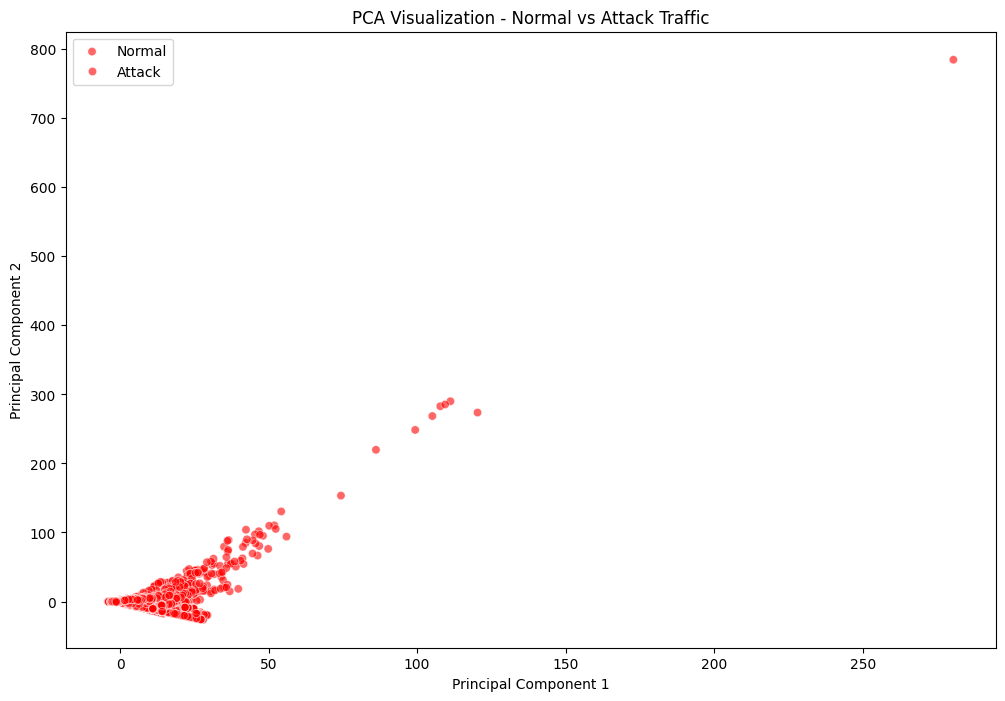

In [17]:
# Plot PCA results with normal vs attack labels
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_binary, palette={0: 'blue', 1: 'red'}, alpha=0.6)
plt.title('PCA Visualization - Normal vs Attack Traffic')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(labels=['Normal', 'Attack'])
plt.show()

Visualizing feature distributions...


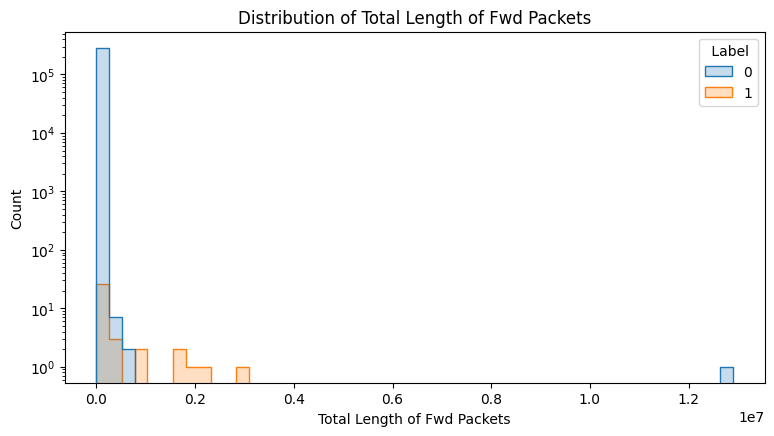

In [18]:
# Distribution of some key features
print("Visualizing feature distributions...")
key_features = ['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 
                'Total Length of Fwd Packets', 'Flow Packets/s']

plt.figure(figsize=(15, 12))
for i, feature in enumerate(key_features):
    if feature in X.columns:
        plt.subplot(3, 2, i+1)
        sns.histplot(data=df, x=feature, hue=' Label', element='step', bins=50, common_norm=False)
        plt.title(f'Distribution of {feature}')
        plt.yscale('log')
plt.tight_layout()
plt.show()

Creating correlation matrix...


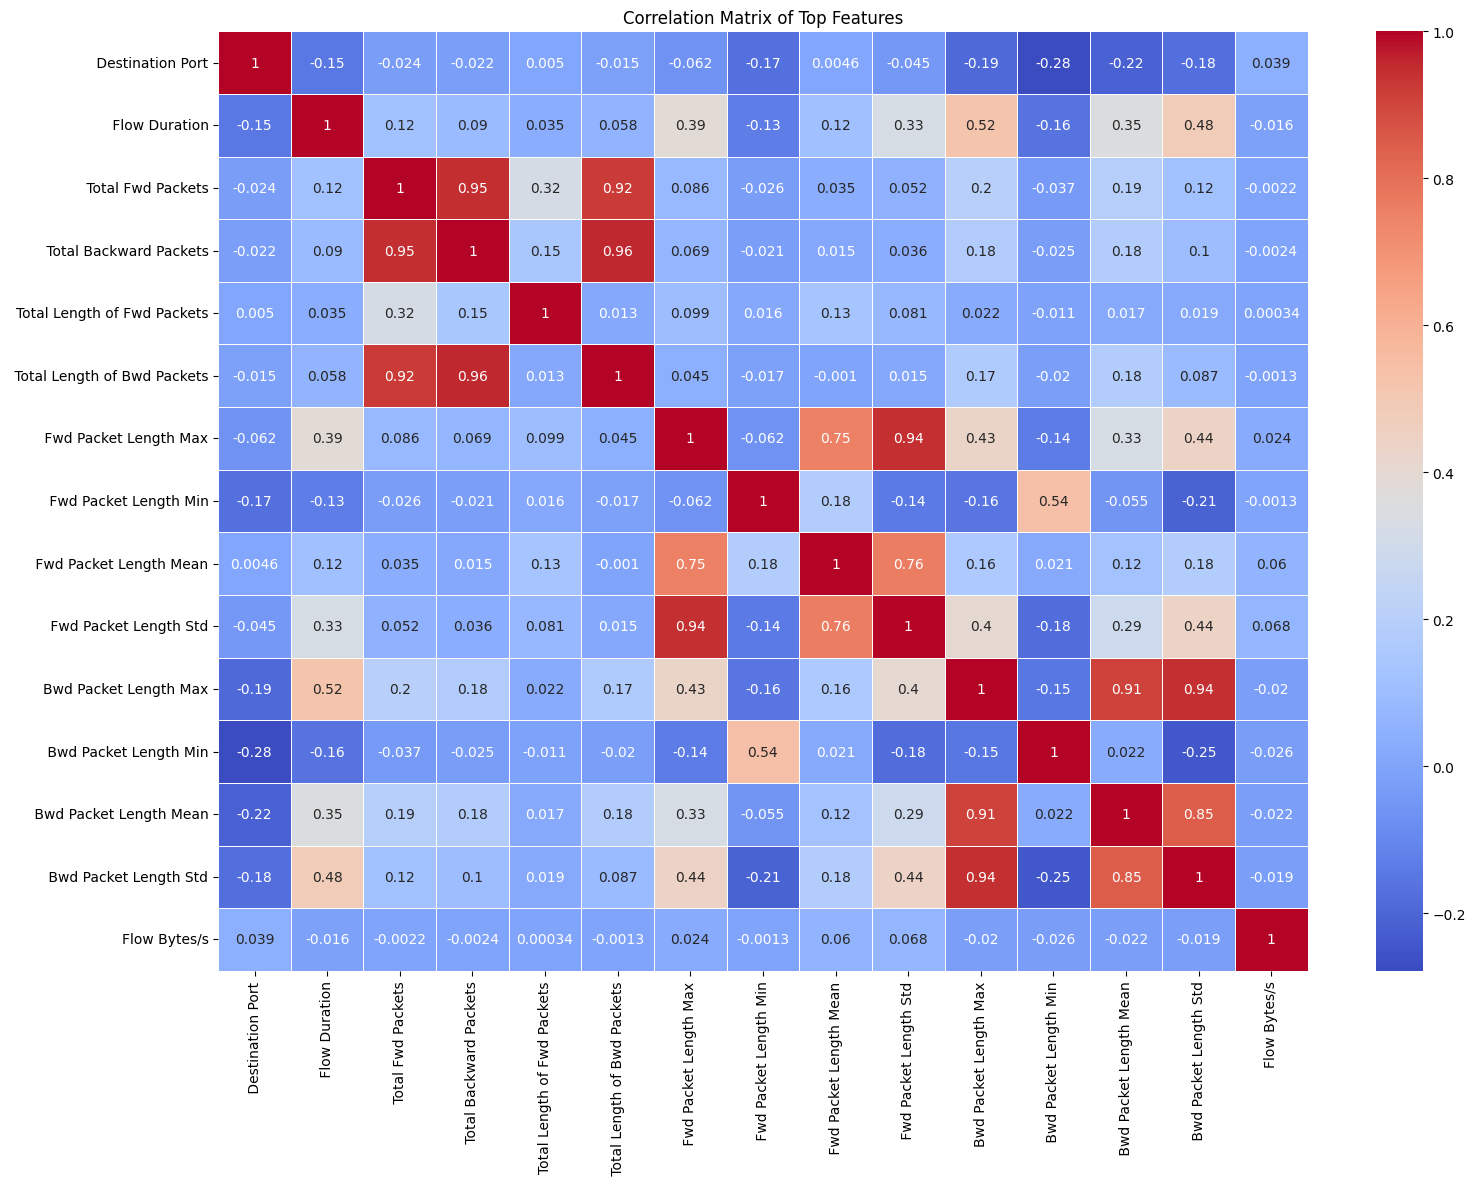

In [19]:
# Correlation matrix for top features
print("Creating correlation matrix...")
plt.figure(figsize=(16, 12))
top_features = X.columns[:15]  # Top 15 features
correlation_matrix = df[top_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Top Features')
plt.tight_layout()
plt.show()

## 4. Clustering with DBSCAN for Anomaly Detection

In [20]:
# Split data for training
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_binary, test_size=0.3, random_state=42)

In [21]:
# Apply DBSCAN
print("Applying DBSCAN...")
dbscan = DBSCAN(eps=0.5, min_samples=5, n_jobs=-1)
dbscan_labels = dbscan.fit_predict(X_train)

Applying DBSCAN...


In [22]:
# Analyze DBSCAN results
print(f"Number of clusters found: {len(np.unique(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)}")
print(f"Number of noise points: {(dbscan_labels == -1).sum()}")

Number of clusters found: 1018
Number of noise points: 21836


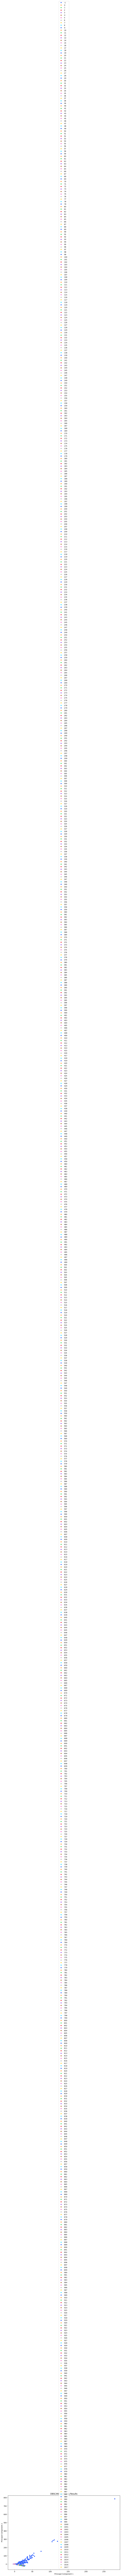

In [23]:
# Visualize clusters
pca_train = pca.transform(X_train)
plt.figure(figsize=(12, 8))
sns.scatterplot(x=pca_train[:, 0], y=pca_train[:, 1], hue=dbscan_labels, palette='bright', legend='full')
plt.title('DBSCAN Clustering Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

#### *** UPDATED: Remove noise points before model training ***

In [24]:
# print("\n--- Removing Noise Points ---")
# # Get indices of non-noise points
# non_noise_indices = np.where(dbscan_labels != -1)[0]
# print(f"Keeping {len(non_noise_indices)} points after removing noise")

In [25]:
# # Filter out noise points
# X_train_filtered = X_train[non_noise_indices]
# y_train_filtered = y_train.iloc[non_noise_indices]

In [26]:
# # Visualize filtered data
# pca_train_filtered = pca_train[non_noise_indices]
# plt.figure(figsize=(12, 8))
# sns.scatterplot(x=pca_train_filtered[:, 0], y=pca_train_filtered[:, 1], 
#                 hue=dbscan_labels[non_noise_indices], palette='bright', legend='full')
# plt.title('DBSCAN Clusters After Removing Noise Points')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.show()

In [27]:
# # Compare distribution of classes before and after removing noise
# plt.figure(figsize=(10, 6))
# plt.subplot(1, 2, 1)
# sns.countplot(x=y_train)
# plt.title('Class Distribution Before Removing Noise')
# plt.xticks([0, 1], ['Normal', 'Attack'])

# plt.subplot(1, 2, 2)
# sns.countplot(x=y_train_filtered)
# plt.title('Class Distribution After Removing Noise')
# plt.xticks([0, 1], ['Normal', 'Attack'])
# plt.tight_layout()
# plt.show()

## 5. Supervised Learning with Random Forest

In [28]:
# Add DBSCAN cluster as a feature
X_train_with_cluster = np.column_stack((X_train, dbscan_labels))
X_test_with_cluster = np.column_stack((X_test, dbscan.fit_predict(X_test)))

In [29]:
# Train Random Forest on filtered data
print("Training Random Forest model...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_with_cluster, y_train)

Training Random Forest model...


RandomForestClassifier(n_jobs=-1, random_state=42)

In [30]:
# Save the model
joblib.dump(rf_model, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [31]:
# Make predictions
y_pred = rf_model.predict(X_test_with_cluster)

## 6. Model Evaluation

In [32]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000


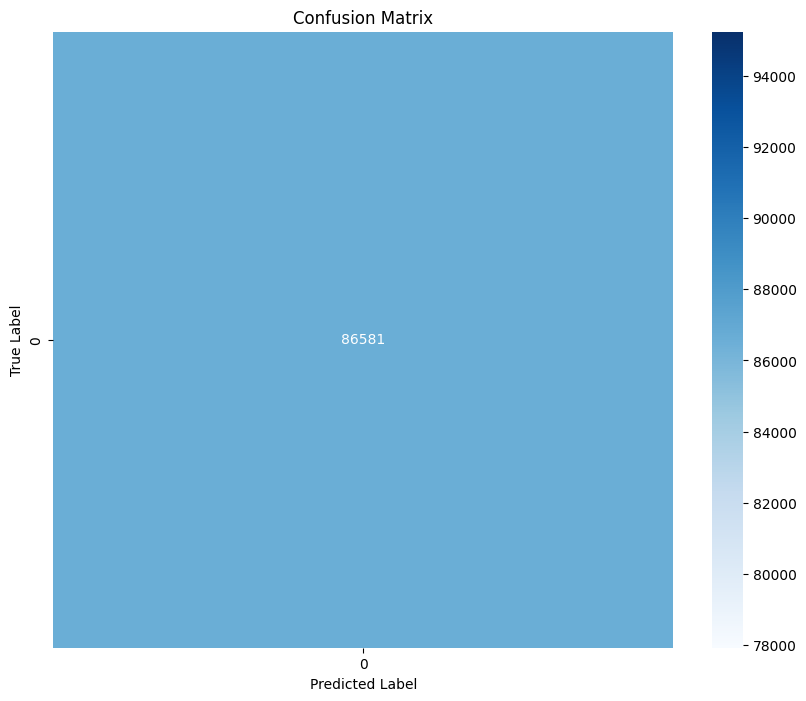

In [33]:
# Display confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [34]:
# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     86581

    accuracy                           1.00     86581
   macro avg       1.00      1.00      1.00     86581
weighted avg       1.00      1.00      1.00     86581



## 7. Feature Importance

In [35]:
# Get feature importance from Random Forest
feature_names = list(X.columns) + ['DBSCAN_Cluster']
feature_importances = rf_model.feature_importances_

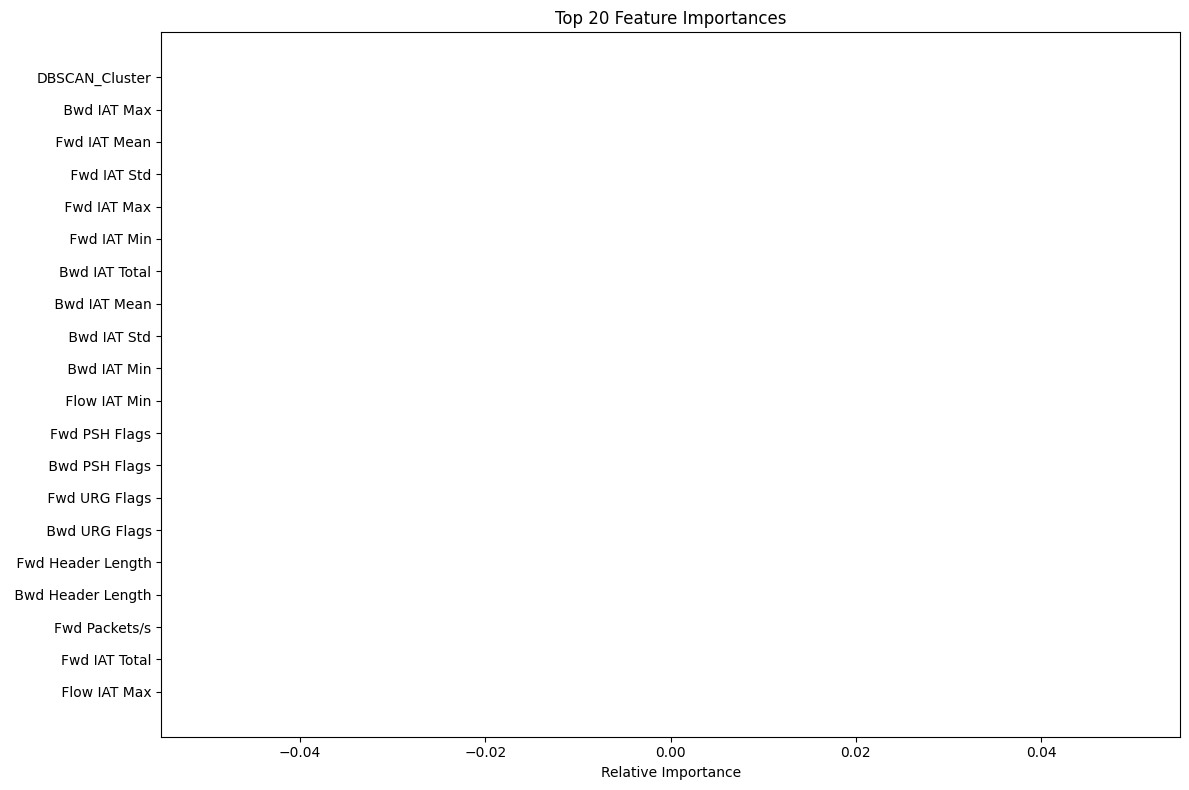

In [36]:
# Sort features by importance
indices = np.argsort(feature_importances)[-20:]  # Top 20 features
plt.figure(figsize=(12, 8))
plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.title('Top 20 Feature Importances')
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()

## 8. Performance Comparison (with vs without noise removal)

In [37]:
# Train a model on the original data (with noise points)
print("Training comparison model on unfiltered data...")
rf_model_with_noise = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
X_train_with_noise_cluster = np.column_stack((X_train, dbscan_labels))
rf_model_with_noise.fit(X_train_with_noise_cluster, y_train)

Training comparison model on unfiltered data...


RandomForestClassifier(n_jobs=-1, random_state=42)

In [38]:
# Make predictions
y_pred_with_noise = rf_model_with_noise.predict(X_test_with_cluster)

In [39]:
# Calculate metrics for model trained with noise
accuracy_with_noise = accuracy_score(y_test, y_pred_with_noise)
precision_with_noise = precision_score(y_test, y_pred_with_noise, average='weighted')
recall_with_noise = recall_score(y_test, y_pred_with_noise, average='weighted')

In [40]:
# Print comparison
print("\nPerformance Comparison:")
print(f"{'Metric':<20} {'With Noise':<15} {'Without Noise':<15} {'Difference':<15}")
print(f"{'-'*60}")
print(f"{'Accuracy':<20} {accuracy_with_noise:<15.4f} {accuracy:<15.4f} {accuracy - accuracy_with_noise:<15.4f}")
print(f"{'Precision':<20} {precision_with_noise:<15.4f} {precision:<15.4f} {precision - precision_with_noise:<15.4f}")
print(f"{'Recall':<20} {recall_with_noise:<15.4f} {recall:<15.4f} {recall - recall_with_noise:<15.4f}")


Performance Comparison:
Metric               With Noise      Without Noise   Difference     
------------------------------------------------------------
Accuracy             1.0000          1.0000          0.0000         
Precision            1.0000          1.0000          0.0000         
Recall               1.0000          1.0000          0.0000         


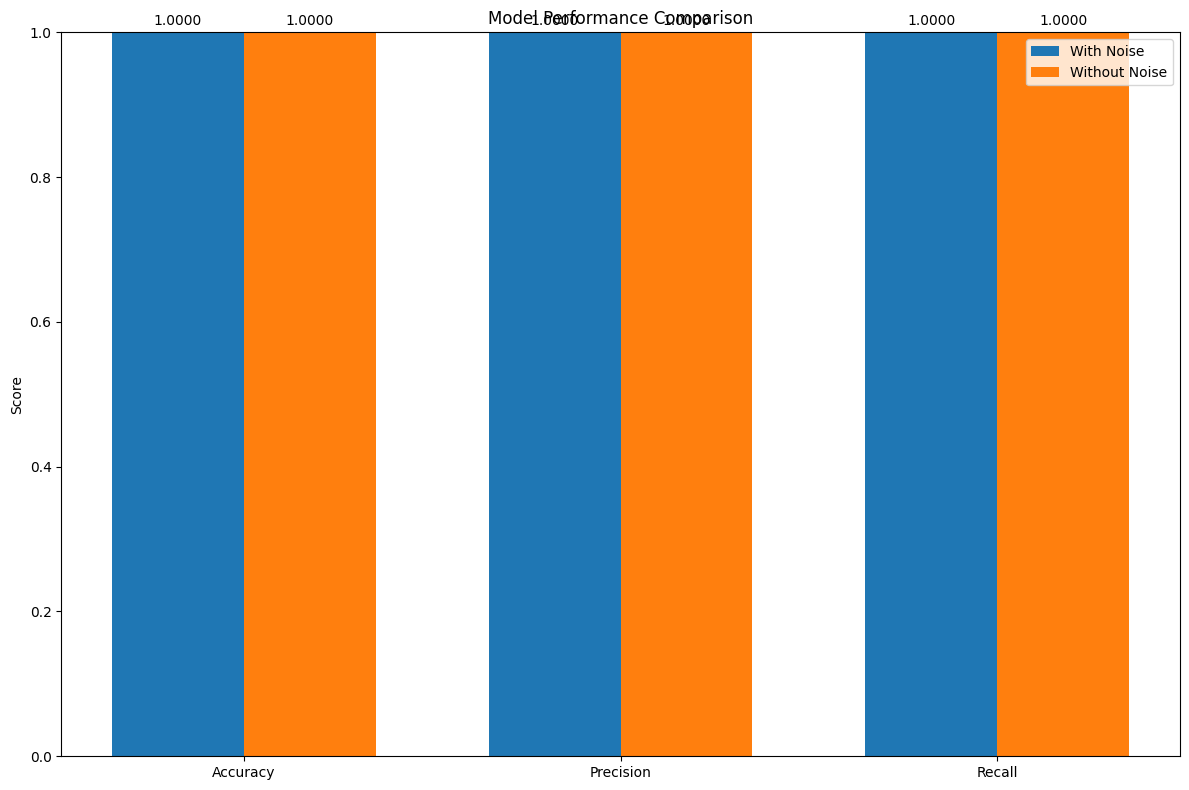

In [41]:
# Visualize comparison
metrics = ['Accuracy', 'Precision', 'Recall']
with_noise = [accuracy_with_noise, precision_with_noise, recall_with_noise]
without_noise = [accuracy, precision, recall]

plt.figure(figsize=(12, 8))
x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, with_noise, width, label='With Noise')
plt.bar(x + width/2, without_noise, width, label='Without Noise')

plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, metrics)
plt.legend()
plt.ylim(0, 1)

for i, v in enumerate(with_noise):
    plt.text(i - width/2, v + 0.01, f'{v:.4f}', ha='center')

for i, v in enumerate(without_noise):
    plt.text(i + width/2, v + 0.01, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.show()